# Test velocity unfolding.

The whole day (2014/01/14) is an interesting case (among others) as it is particulary difficult to unfold properly.

In [23]:
%matplotlib inline
import os
import glob

import pyart
import numpy as np
import matplotlib.pyplot as pl

from numpy import pi
from processing_codes import radar_codes

In [6]:
INPATH = "/g/data2/rr5/vhl548/CPOL_level_1a/2006/20060114/"
SOUND_DIR = "/g/data2/rr5/vhl548/soudings_netcdf/"
flist = sorted(glob.glob(os.path.join(INPATH, "*.nc")))

In [3]:
radar = pyart.io.read(flist[15])

In [17]:
radar.fields['VEL']['units'] = "m/s"

In [18]:
gr = pyart.graph.RadarDisplay(radar)

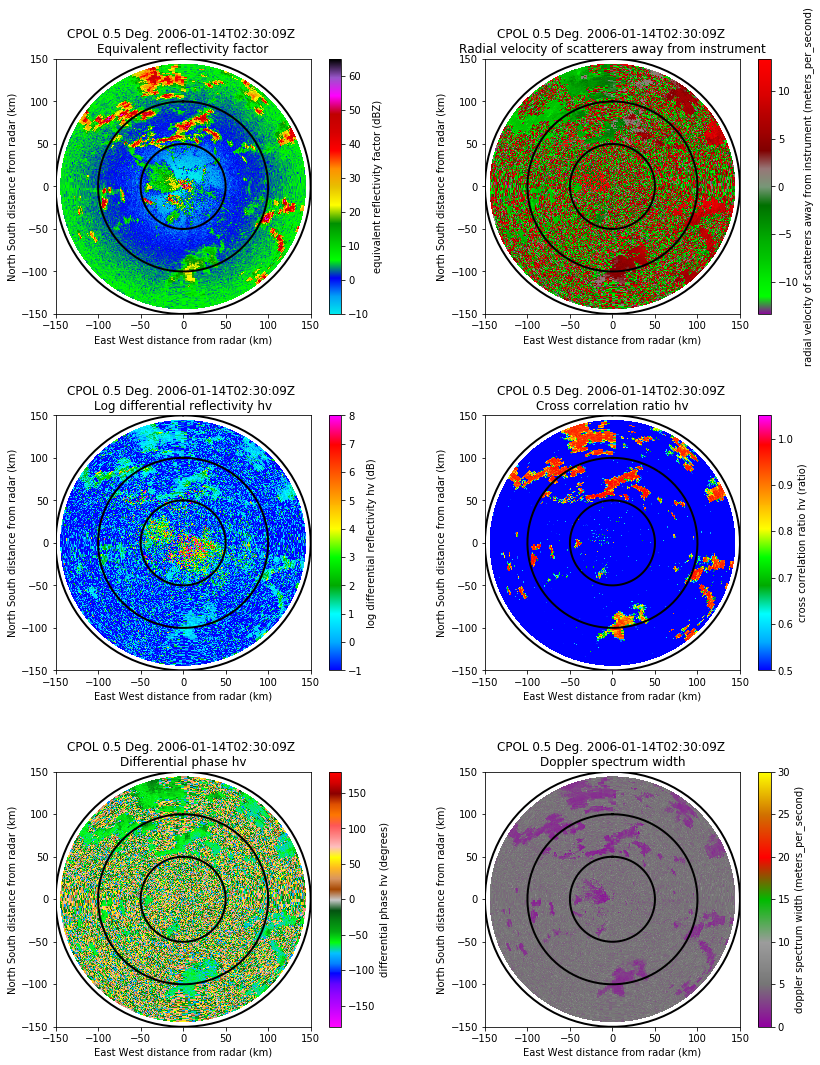

In [5]:
fig, ax = pl.subplots(3, 2, figsize=(12, 15))
ax = ax.flatten()

gr.plot_ppi("DBZ", ax=ax[0])
gr.plot_ppi("VEL", ax=ax[1], cmap='pyart_NWSVel')
gr.plot_ppi("ZDR", ax=ax[2], cmap='pyart_RefDiff', vmin=-1, vmax=8)
gr.plot_ppi("RHOHV", ax=ax[3], cmap='pyart_RefDiff', vmin=0.5, vmax=1.05)
gr.plot_ppi("PHIDP", ax=ax[4], cmap='pyart_Wild25', vmin=-180, vmax=180)
gr.plot_ppi("WIDTH", ax=ax[5], cmap='pyart_NWS_SPW', vmin=0, vmax=30)

for myax in ax:
    gr.plot_range_rings([50, 100, 150], ax=myax)
    myax.axis((-150, 150, -150, 150))
    myax.set_aspect('equal')

fig.tight_layout()
pl.show()


Here we compute the SNR, correct $\rho_{hv}$ and then compute a gatefilter.

In [7]:
height, temperature, snr = radar_codes.snr_and_sounding(radar, soundings_dir=SOUND_DIR)
radar.add_field('temperature', temperature, replace_existing=True)
radar.add_field('height', height, replace_existing=True)
radar.add_field('SNR', snr, replace_existing=True)

In [8]:
rho_corr = radar_codes.correct_rhohv(radar)
radar.add_field_like('RHOHV', 'RHOHV_CORR', rho_corr, replace_existing=True)
gatefilter = radar_codes.do_gatefilter(radar, rhohv_name='RHOHV_CORR')

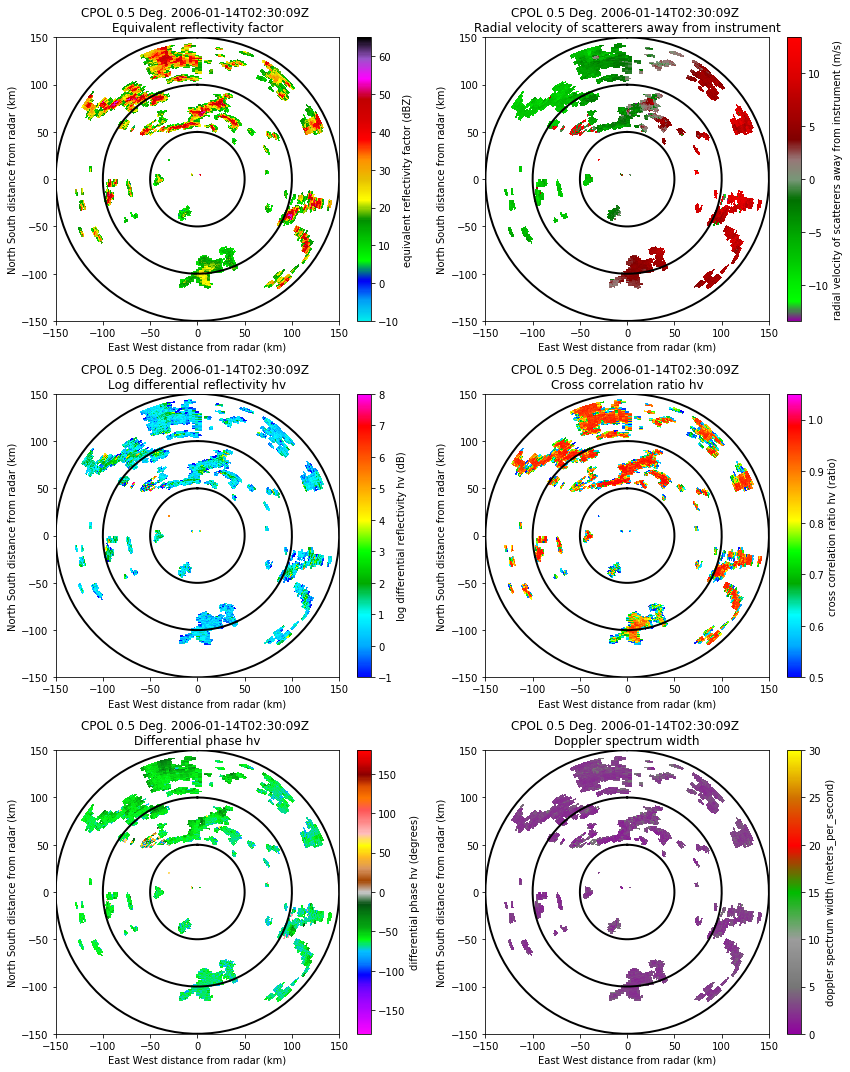

In [22]:
fig, ax = pl.subplots(3, 2, figsize=(12, 15))
ax = ax.flatten()

gr.plot_ppi("DBZ", ax=ax[0], gatefilter=gatefilter)
gr.plot_ppi("VEL", ax=ax[1], cmap='pyart_NWSVel', gatefilter=gatefilter)
gr.plot_ppi("ZDR", ax=ax[2], cmap='pyart_RefDiff', vmin=-1, vmax=8, gatefilter=gatefilter)
gr.plot_ppi("RHOHV_CORR", ax=ax[3], cmap='pyart_RefDiff', vmin=0.5, vmax=1.05, gatefilter=gatefilter)
gr.plot_ppi("PHIDP", ax=ax[4], cmap='pyart_Wild25', vmin=-180, vmax=180, gatefilter=gatefilter)
gr.plot_ppi("WIDTH", ax=ax[5], cmap='pyart_NWS_SPW', vmin=0, vmax=30, gatefilter=gatefilter)

for myax in ax:
    gr.plot_range_rings([50, 100, 150], ax=myax)
    myax.axis((-150, 150, -150, 150))
    myax.set_aspect('equal')

fig.tight_layout()
pl.show()

We unfold the velocity using the region based algorithm.

In [10]:
vdop_unfold = radar_codes.unfold_velocity(radar, gatefilter, bobby_params=True, vel_name='VEL')
radar.add_field('VEL_UNFOLDED', vdop_unfold, replace_existing=True)

Here we plot the first 10 elevation scans.

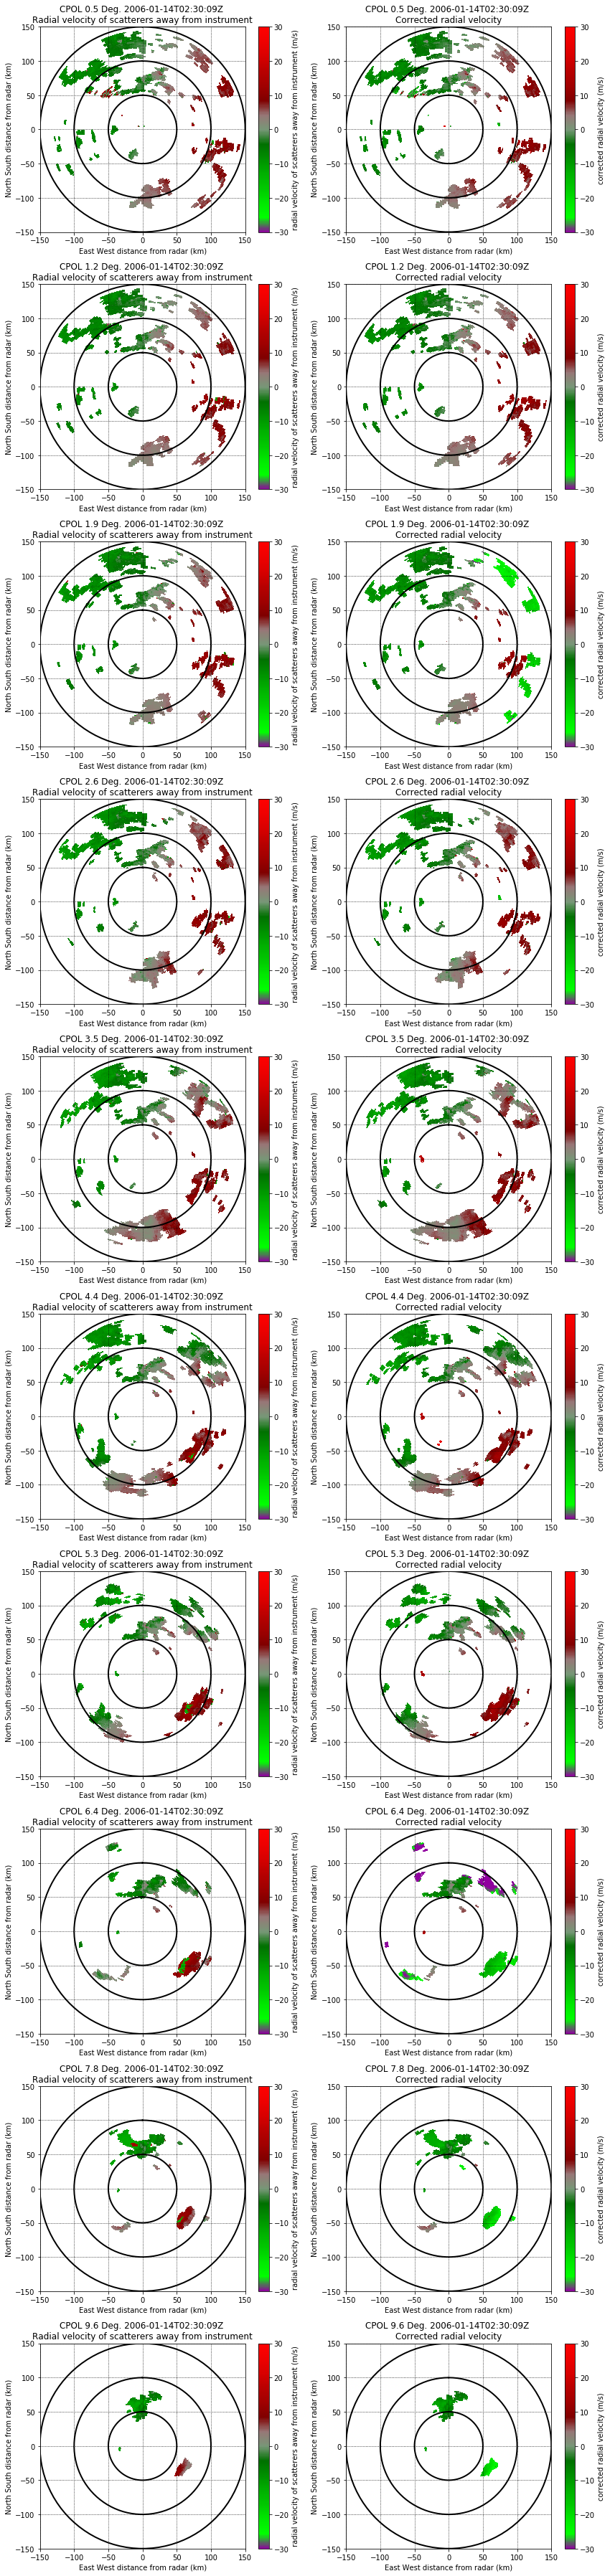

In [25]:
fig, ax = pl.subplots(10, 2, figsize=(12, 50))
ax = ax.flatten()

for sweep in range(10):
    gr.plot_ppi("VEL", ax=ax[2 * sweep], cmap='pyart_NWSVel', gatefilter=gatefilter, sweep=sweep, vmin=-30, vmax=30)
    gr.plot_ppi("VEL_UNFOLDED", ax=ax[2 * sweep + 1], cmap='pyart_NWSVel', gatefilter=gatefilter, sweep=sweep, vmin=-30, vmax=30)

for myax in ax:
    gr.plot_range_rings([50, 100, 150], ax=myax)
    gr.plot_grid_lines(ax=myax)
    myax.axis((-150, 150, -150, 150))
    myax.set_aspect('equal')
    
fig.tight_layout()
pl.show()

Showing a cross section. The velocity unfolding flips from one elevation to another.

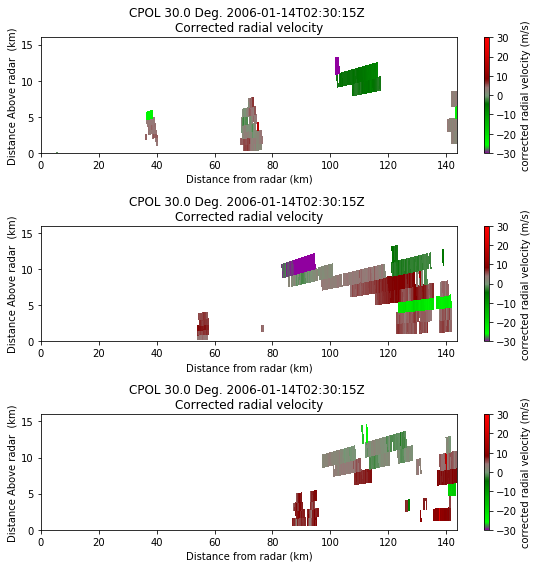

In [49]:
xsect = pyart.util.cross_section_ppi(radar, [30, 45, 60])

gr = pyart.graph.RadarDisplay(xsect)
fig, ax = pl.subplots(3, 1, figsize=(8, 8))
# ax = ax.flatten()

gr.plot('VEL_UNFOLDED', 0, cmap='pyart_NWSVel', vmin=-30, vmax=30, ax=ax[0])
gr.plot('VEL_UNFOLDED', 1, cmap='pyart_NWSVel', vmin=-30, vmax=30, ax=ax[1])
gr.plot('VEL_UNFOLDED', 2, cmap='pyart_NWSVel', vmin=-30, vmax=30, ax=ax[2])

for myax in ax:
    myax.set_ylim(0, 16)
    
fig.tight_layout()
pl.show()


Here I plot the vertical gradirent of the unfolded velocity (bottom panel)

In [102]:
vel = xsect.fields['VEL_UNFOLDED']['data'][xsect.get_slice(1)].copy()
dvdy = np.ma.masked_where(vel.mask, np.gradient(vel.filled(0), axis=0))

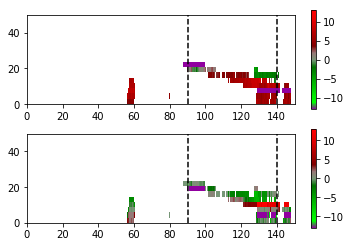

In [105]:
pl.subplot(211)
pl.imshow(vel, cmap='pyart_NWSVel', extent=[0, 150, 0, 50], vmin=-13, vmax=13, origin='lower')
pl.plot([90, 90], [0, 50], 'k--')
pl.plot([140, 140], [0, 50], 'k--')
pl.colorbar()
# pl.ylim(0, 20)

pl.subplot(212)
pl.imshow(dvdy, cmap='pyart_NWSVel', extent=[0, 150, 0, 50], vmin=-13, vmax=13, origin='lower')
pl.plot([90, 90], [0, 50], 'k--')
pl.plot([140, 140], [0, 50], 'k--')
pl.colorbar()
# pl.ylim(0, 20)

pl.show()

Below are the 2 vertical profiles corresponding to the dashed lines.

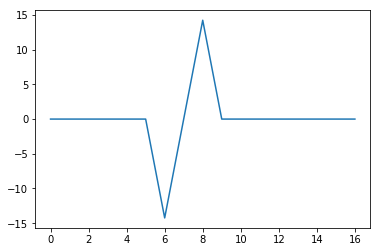

In [98]:
pl.plot(dvdy[:, 288])

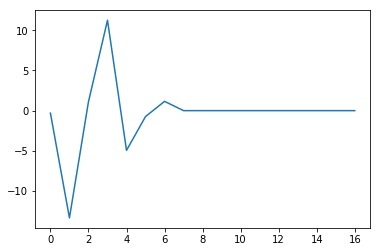

In [100]:
pl.plot(dvdy[:, 440])

The gradient between a wrongfully unfolded elevation and another is equal to the nyquist velocity. 